<a href="https://colab.research.google.com/github/grace3999/PPs/blob/master/4_FIFI_image_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import pandas as pd
import os
import requests 
from multiprocessing.pool import ThreadPool
import time
import random
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [3]:
#get list of photo urls corresponding to each FIFI category

#path for FIFI cleaned and preprocessed data frame
path_FIFI = '/content/gdrive/My Drive/WIDS_FIFI_groupproject/generated_datasets/data_final.pkl'

#read in pkl file containing 
data = pd.read_pickle(path_FIFI)
data = pd.DataFrame(data = data)
data.reset_index(inplace=True, drop=True)

print('Original data shape:\n', data.shape, '\n')
print('Original data columns:\n', data.columns.values, '\n')

data = data[data['FIFI_category'] != 'Community Walk']

data['FIFI_category'] = data['FIFI_category'].replace({'Needles/Dumping': 'Needles_Dumping', 'Sign/Signal': 'Sign_Signal'})

#we are only interested in FIFI requests that have a photo included with the request
print(data.shape)
data_photo = data[~data['Photo'].isna()]
print(data_photo.shape)

print(data_photo['FIFI_category'].value_counts())

#create a directory for each category
os.mkdir('/tmp/FIFI_photos/')
save_path = '/tmp/FIFI_photos/'

cats_to_dl = ['Abnd_Vehicle', 'Grafitti', 'Needles_Dumping', 'Parking',
       'Pothole', 'Streetlight', 'Other', 'Clogged_Drain', 'Dead Animal',
       'Vegetation', 'Sign_Signal']

#get and save photos according to FIFI_category
for cat in cats_to_dl:
    if os.path.exists(os.path.join(save_path, cat)) == True:
      print(cat, " already exists")
    else:
      os.mkdir(os.path.join(save_path, cat))
      print(cat, " directory created")

Original data shape:
 (248815, 67) 

Original data columns:
 ['Service_Request_Number' 'Created_Date' 'Location' 'Location_Details'
 'Description' 'License_Number' 'State' 'Vehicle_Make' 'Vehicle_Color'
 'Time_parked' 'Photo' 'FIFI_category' 'Location_Details.1'
 'Property_damage?' 'Current_Issue' 'Type_of_animal'
 'On_private_property?' 'Graffiti_location' 'Location_and_Description'
 'Obscene/Racial/Hateful?' 'Street/Intersection' 'Where?' 'Type_of_item?'
 'Veg_location' 'Vegetation_Safety_Issue' 'Parking_Violation_Concerning'
 'License_Plate_Number' 'Location_details' '7_digit_number_on_pole'
 'Issue' 'date' 'year' 'month' 'day' 'day_of_week' 'hour' 'zip'
 'neighborhood' 'SittingInformal' 'Lying' 'DisruptiveActivity_Aggressive'
 'DisruptiveActivity_Intoxicated' 'LivingActivities' 'Soliciting'
 'overdose' 'pop' 'pop_dens' 'housing_units' 'med_home' 'land_area'
 'occupied_units' 'occupied_ratio' 'med_income' 'med_age' 'male_%'
 'white_%' 'fam_%' 'nokid_%' 'mortgage_%' 'fulltime_%' 'une

In [4]:
#create function to get photo from url and save

def fetch_and_save(image_url_tupple):
    image_name, image_url = image_url_tupple
    #create file name for photo
    image_name = os.path.join(save_path_cat, image_name)  
    #get photo from url and save
    r = requests.get(image_url, allow_redirects=True)
    open(image_name, 'wb').write(r.content)

#do each category individually and 5,000 at a time (runtime keeps dying)
save_path = '/tmp/FIFI_photos/'

#only use categories that have at least 2000 images
cats_to_dl = ['Abnd_Vehicle', 'Grafitti', 'Needles_Dumping', 'Parking',
       'Pothole', 'Streetlight', 'Sign_Signal', 'Other']

for cat in cats_to_dl:
  print(cat)
  cat_data = data_photo[data_photo['FIFI_category'] == cat].reset_index() #index will get saved as part of file name for later use

  save_path_cat = os.path.join(save_path, cat)

  i = 0
  while i < (1000):
    if i%100 == 0:
      print(i)
    urls = list(zip([cat+'_'+str(x)+'.jpeg' for x in cat_data['Service_Request_Number'].iloc[i:i+5]], cat_data['Photo'][i:i+5]))
    ThreadPool(5).imap_unordered(fetch_and_save, urls)
    i += 5

Abnd_Vehicle
0
100
200
300
400
500
600
700
800
900
Grafitti
0
100
200
300
400
500
600
700
800
900
Needles_Dumping
0
100
200
300
400
500
600
700
800
900
Parking
0
100
200
300
400
500
600
700
800
900
Pothole
0
100
200
300
400
500
600
700
800
900
Streetlight
0
100
200
300
400
500
600
700
800
900
Sign_Signal
0
100
200
300
400
500
600
700
800
900
Other
0
100
200
300
400
500
600
700
800
900


In [0]:
#create directories for training and testing 
project_dir = '/tmp/'

try:
  os.mkdir(os.path.join(project_dir, 'cnn_cat_other'))
except OSError:
  pass
try:
  os.mkdir(os.path.join(project_dir, 'cnn_cat_other/training'))
except OSError:
  pass
try:
  os.mkdir(os.path.join(project_dir, 'cnn_cat_other/testing'))
except OSError:
  pass


In [0]:
#create directories for train/test for each FIFI category 
photo_categories = ['Abnd_Vehicle', 'Grafitti', 'Needles_Dumping', 'Parking',
       'Pothole', 'Streetlight', 'Sign_Signal']

train_dir = '/tmp/cnn_cat_other/training/'
test_dir = '/tmp/cnn_cat_other/testing/'

for cat in photo_categories:
  try:
    os.mkdir(os.path.join(train_dir, cat))
  except OSError:
   print('cannot make directory for train: ', cat)
  try:
    os.mkdir(os.path.join(test_dir, cat))
  except OSError:
   print('cannot make directory for test: ', cat)

In [0]:
#function to split data into training and testing based on a specified split size
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = os.path.join(SOURCE, filename)
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(TRAINING, filename)
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = os.path.join(SOURCE, filename)
        destination = os.path.join(TESTING, filename)
        copyfile(this_file, destination)

In [10]:
photos_dir = '/tmp/FIFI_photos/'
train_dir = '/tmp/cnn_cat_other/training/'
test_dir = '/tmp/cnn_cat_other/testing/'

for cat in photo_categories:
  print(cat)
  source_dir = os.path.join(photos_dir, cat)
  train_dir_cat = os.path.join(train_dir, cat)
  test_dir_cat = os.path.join(test_dir, cat)

  split_size = .9
  start_time = time.time()
  split_data(source_dir, train_dir_cat, test_dir_cat, split_size)
  print("--- %s seconds ---" % (time.time() - start_time))


Abnd_Vehicle
--- 0.35900354385375977 seconds ---
Grafitti
--- 0.24996733665466309 seconds ---
Needles_Dumping
--- 0.49175024032592773 seconds ---
Parking
--- 0.30872178077697754 seconds ---
Pothole
--- 0.4312722682952881 seconds ---
Streetlight
--- 0.7645056247711182 seconds ---
Sign_Signal
--- 1.2028248310089111 seconds ---


In [12]:
#train CNN using images from each category besides 'other'

TRAINING_DIR = '/tmp/cnn_cat_other/training/'
training_datagen = ImageDataGenerator(rescale = 1./255)

VALIDATION_DIR = '/tmp/cnn_cat_other/testing/'
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])


model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit_generator(train_generator, epochs=10, validation_data = validation_generator, verbose = 1)

#model.save("rps.h5")


Found 6380 images belonging to 7 classes.
Found 789 images belonging to 7 classes.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPool

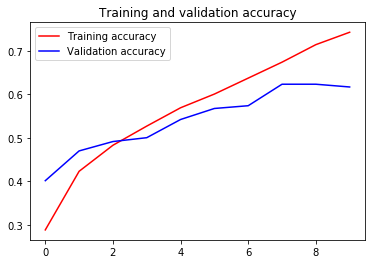

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()